In [1]:
%load_ext autoreload
%autoreload 2

## EDA

### Исходные данные
- **Блюда**: 3262 блюда с изображениями (RGB, 640x480), калорийностью, массой и списком ингредиентов
- **Ингредиенты**: 555 уникальных ингредиентов

### Целевое значение

В таблице блюд даны значения общего веса и калорийности блюда. В качестве единого нормализованного показателя для предсказания моделью выбрано значение калорийности на 100г блюда.

### Предобработка

- **Изображения**: Ресайз до 224×224, нормализация, аугментация
- **Текст**: Преобразование ID ингредиентов в названия, токенизация

На фотографиях блюдо размещено на тарелке. В зависимости от размера тарелки и блюда, основные ингредиенты могут располагаться в разных местах относительно центра изображения. В качестве аугментаций выбраны следующие преобразования:

- Геометрические трансформации (поворот, масштаб, сдвиг) - симуляция вариативности положение блюда
- Цветовые искажения (яркость, контраст, насыщенность) - аугментация условий съемок
- Аугментация прямоугольными шумами

### Функция потерь

SmoothL1Loss с β=20 (Huber-loss)

Основной ориентир качества предсказания - средняя абсолютная ошибка (MAE). Целевой показатель - 50 MAE. Функция потерь выбрана для более быстрого обучения на больших ошибках > 20 и более аккуратного на малых ошибках.

In [2]:
# Конфигурация обучения
class Config:
    SEED = 42

    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    # Разморозка слоев
    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    # Гиперпараметры
    BATCH_SIZE = 256 
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 3e-3
    EPOCHS = 35
    DROPOUT = 0.3
    HIDDEN_DIM = 256

    # Пути к данным
    IMAGES_DIR = "data/images"
    INGREDIENTS_PATH = "data/ingredients.csv"
    DISHES_PATH = "data/dish.csv"
    SAVE_PATH = "best_model.pth"

## Визуализируем изображения тренировочного датасета

Убедимся в корректности аугментированных изображений и списка ингредиентов

/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


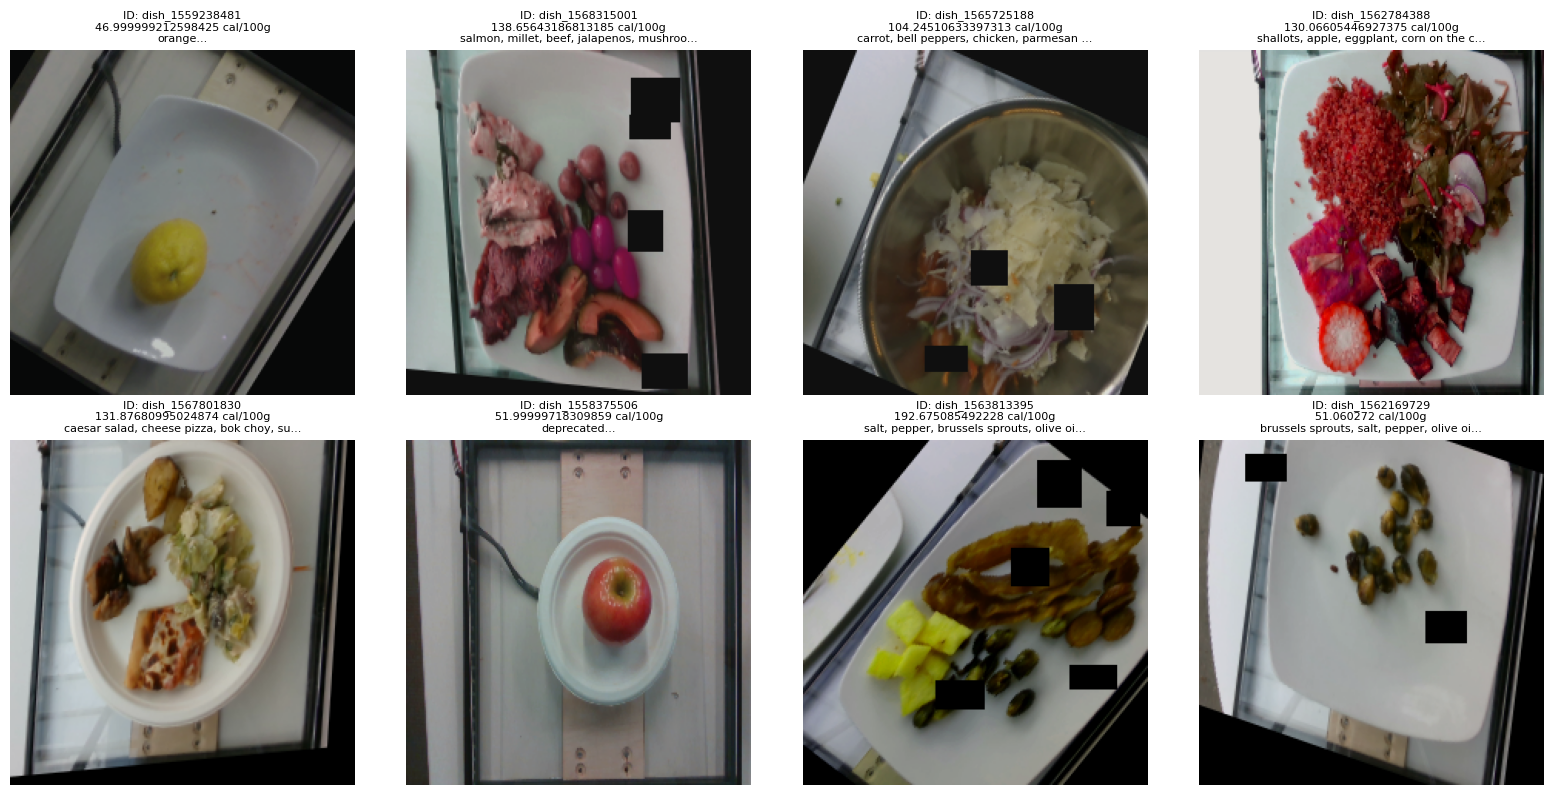

In [3]:
from scripts.dataset import MultimodalDataset, get_transforms
from scripts.visualize import visualize_dataset

cfg = Config()
transforms = get_transforms(cfg)
train_dataset = MultimodalDataset(cfg, transforms)

visualize_dataset(train_dataset)

## Обучение модели

In [4]:
import torch
from scripts.utils import train

cfg = Config()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

train(cfg, device) 

Using device: cuda
Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pool

## Проанализируем показатели модели на тестовых данных

Using device: cuda
Loading model from best_model.pth


Evaluating on test dataset with 507 samples
Mean Absolute Error (MAE): 48.0270
Mean prediction: 105.24
Mean target: 143.62
Max error: 432.49
Min error: 0.03

Top 10 worst predictions:
--------------------------------------------------------------------------------
1. Dish ID: dish_1558549413
   Text: almonds...
   Predicted: 145.61 cal/100g
   Actual: 578.10 cal/100g
   Error: 432.49
--------------------------------------------------------------------------------
2. Dish ID: dish_1558719994
   Text: almonds...
   Predicted: 145.76 cal/100g
   Actual: 578.10 cal/100g
   Error: 432.34
--------------------------------------------------------------------------------
3. Dish ID: dish_1558722125
   Text: almonds...
   Predicted: 145.91 cal/100g
   Actual: 578.10 cal/100g
   Error: 432.19
--------------------------------------------------------------------------------
4. Dish ID: dish_1558375667
   Text: almonds...
   Predicted: 146.16 cal/100g
   Actual: 578.10 cal/100g
   Error: 431.94
----

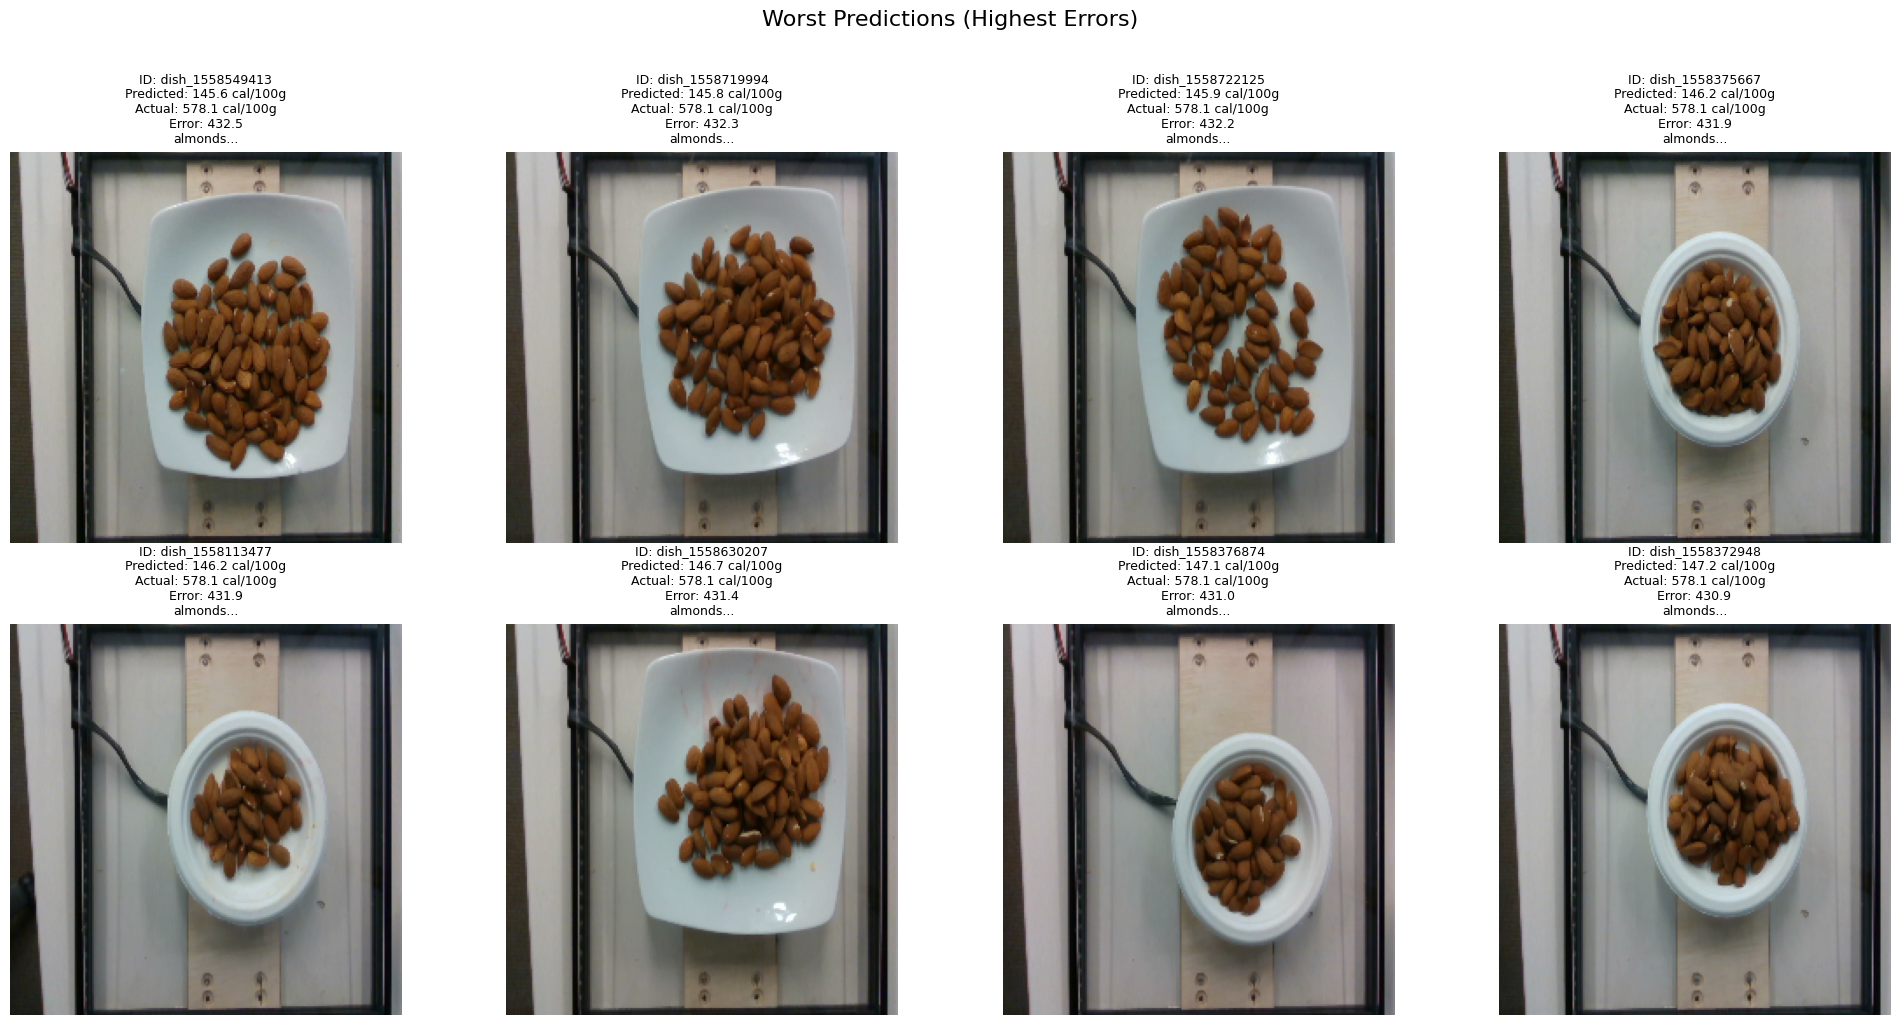

Total samples: 507
MAE: 48.0270 cal/100g
Worst error: 432.49 cal/100g
Best error: 0.03 cal/100g


In [5]:
from scripts.utils import evaluate_model, load_model, inference_and_evaluate
from scripts.visualize import visualize_worst_predictions
from scripts.dataset import MultimodalDataset, get_transforms

cfg = Config()

results, worst_predictions = evaluate_model(
    config=cfg, 
    model_path=cfg.SAVE_PATH,
    dataset_type="test", 
    top_k_worst=10
)

# Визуализация худших предсказаний
test_transforms = get_transforms(cfg, ds_type="test")
test_dataset = MultimodalDataset(cfg, test_transforms, ds_type="test")
visualize_worst_predictions(test_dataset, worst_predictions, num_images=8)
    
print(f"Total samples: {len(results['predictions'])}")
print(f"MAE: {results['mae']:.4f} cal/100g")
print(f"Worst error: {max(results['errors']):.2f} cal/100g")
print(f"Best error: {min(results['errors']):.2f} cal/100g")

## Анализ ошибок

Модель показывает занижение калорийности для высококалорийных продуктов, превышающих средние значения по датасету в несколько раз. Наибольшие ошибки наблюдаются на блюдах с миндалем.

### Возможные улучшения

1. **Архитектура**
   - Использование более крупных моделей
   - Cross-modal attention между изображением и текстом

2. **Данные**
   -  Балансировка датасета по калорийности (увеличение числа примеров для высококалорийных блюд)